In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

import scipy.io as sio
slim = tf.contrib.slim

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../processing/')

In [2]:
from nets import txtbox_300, textbox_common, np_methods
from processing import txt_preprocessing
from processing import visualization

In [3]:
isess = tf.InteractiveSession()

In [4]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = txt_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=txt_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
#reuse = True if 'net' in locals() else None
net = txtbox_300.TextboxNet()
with slim.arg_scope(net.arg_scope(data_format=data_format)):
    localisations, predictions,  _ = net.net(image_4d, is_training=False, reuse=None)



In [5]:
# Restore SSD model.
ckpt_filename = '../checkpoints/model.ckpt-1337.meta'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
#saver = tf.train.import_meta_graph(ckpt_filename)
saver.restore(isess, '../checkpoints/model.ckpt-1337')

# SSD default anchor boxes.
anchors = net.anchors(net_shape)

In [63]:

flogits = []
fgscores = []
flocalisations = []
fglocalisations = []
for i in range(len(predictions)):
    flogits.append(tf.reshape(predictions[i], [-1, 2]))
    flocalisations.append(tf.reshape(localisations[i], [-1, 4]))
# And concat the crap!
logits = tf.concat(flogits, axis=0)
localisations = tf.concat(flocalisations, axis=0)
rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, logits, localisations, bbox_img],
                                                              feed_dict={img_input: img})


In [64]:
rpredictions.shape
#isess.run(tf.nn.softmax(tf.constant([[1.,3.],[2.0,5.0]])))

(23280, 2)

In [55]:

# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.1, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    #rpredictions[0] = rpredictions[0]
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=2, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=10)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

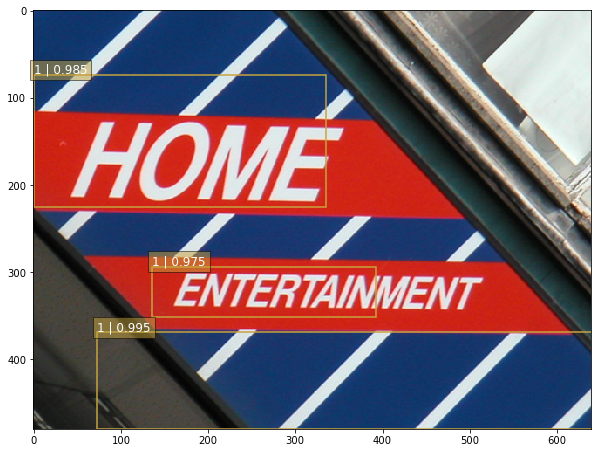

In [56]:
img = mpimg.imread('../data/ICDAR2013/ICDAR-Test-Images/img_105.jpg')
rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)